# Airbnb New User Bookings

Instead of waking to overlooked "Do not disturb" signs, Airbnb travelers find themselves rising with the birds in a whimsical treehouse, having their morning coffee on the deck of a houseboat, or cooking a shared regional breakfast with their hosts.

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

In this recruiting competition, Airbnb challenges you to predict in which country a new user will make his or her first booking.

In [1]:
# import modules
import pickle5 as pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import requests, zipfile
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline
import os
os.getcwd()
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.model_selection import learning_curve, GridSearchCV

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


In [2]:
# read the train and test user files
zf = zipfile.ZipFile('../airbnb/train_users_2.csv.zip')
train = pd.read_csv(zf.open('train_users_2.csv'))


zf = zipfile.ZipFile('../airbnb/test_users.csv.zip')
test = pd.read_csv(zf.open('test_users.csv'))


### Let's check the train and test set.

In [3]:
train.shape , test.shape

((213451, 16), (62096, 15))

In [5]:
train.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [6]:
test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


### Country destination (target variable)


In [7]:
# make a copy of training data
users = train.copy()
# get the count and pct
pd.concat((users.country_destination.value_counts(), users.country_destination.value_counts()/users.shape[0]), axis=1)

,country_destination,country_destination
NDF,124543,0.583473
US,62376,0.292226
other,10094,0.047290
FR,5023,0.023532
IT,2835,0.013282
GB,2324,0.010888
ES,2249,0.010536
CA,1428,0.006690
DE,1061,0.004971
NL,762,0.003570


In [8]:
#Concatenating train and test data for EDA
df_all = pd.concat((train, test), axis = 0, ignore_index= True)

In [9]:
#Finding the number of null entries in each column.
for i in df_all.columns:
    ab = df_all[i].isnull().sum()
    if ab != 0:
        print(i + " has {} null values.".format(ab))
        print()

date_first_booking has 186639 null values.

age has 116866 null values.

first_affiliate_tracked has 6085 null values.

country_destination has 62096 null values.



In [10]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       275547 non-null  object 
 1   date_account_created     275547 non-null  object 
 2   timestamp_first_active   275547 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   275547 non-null  object 
 5   age                      158681 non-null  float64
 6   signup_method            275547 non-null  object 
 7   signup_flow              275547 non-null  int64  
 8   language                 275547 non-null  object 
 9   affiliate_channel        275547 non-null  object 
 10  affiliate_provider       275547 non-null  object 
 11  first_affiliate_tracked  269462 non-null  object 
 12  signup_app               275547 non-null  object 
 13  first_device_type        275547 non-null  object 
 14  firs

In [11]:
print (test.shape) #62096 rows, 15 cols
print (test.date_first_booking.unique()) # contains only nan
test.head()

(62096, 15)
[nan]


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,20140701000215,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,20140701000305,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


### Missing data

After replacing the value '-unknown-' in feature gender with nan we see that 4 features have null values. The date_first_booking nulls can be ignored because they will ultimately not be used to make predictions.

We expect that gender and age have an impact on a user's destination and will look at them more closely.

In [12]:
# replace missing gender data with NaN
users.gender.replace('-unknown-', np.nan, inplace=True)
# compute Nan pct, users
(users.isnull().sum() / users.shape[0]) * 100

id                          0.000000
date_account_created        0.000000
timestamp_first_active      0.000000
date_first_booking         58.347349
gender                     44.829024
age                        41.222576
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     2.841402
signup_app                  0.000000
first_device_type           0.000000
first_browser               0.000000
country_destination         0.000000
dtype: float64

### Gender

MISSING    44.829024
FEMALE     29.534179
MALE       25.504683
OTHER       0.132115
Name: gender, dtype: float64


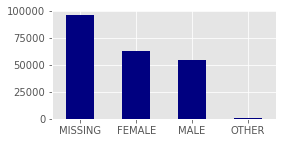

In [13]:
print(users.fillna('MISSING').gender.value_counts()/users.shape[0] * 100)
plt.style.use('ggplot')
plt.figure(figsize=(4,2))
users.fillna('MISSING').gender.value_counts().plot(kind='bar', rot=0, color='navy')
plt.show()

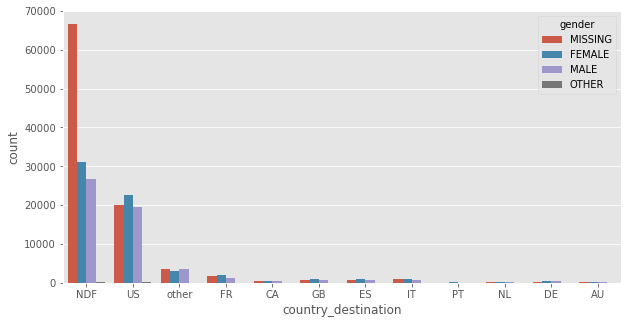

In [14]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x="country_destination", data=users.fillna('MISSING'), hue="gender", 
                   hue_order=['MISSING', 'FEMALE', 'MALE', 'OTHER'])

### Age

In [17]:
# summary stats without removing values
users.age.describe()

count    125461.000000
mean         49.668335
std         155.666612
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

In [18]:
# summary stats after removing values that appear to be year, not age
print ('median', np.median(users.age[users.age<100]))
users.age[users.age<100].describe()

median 34.0


count    123090.000000
mean         36.530937
std          11.673194
min           1.000000
25%          28.000000
50%          34.000000
75%          42.000000
max          99.000000
Name: age, dtype: float64

### Age distribution

In the below chart we can see a modal peak in the 30-35 bucket, with a large proportion of users falling in the 25-35 range.

missing values: 87990
values above 1900: 779


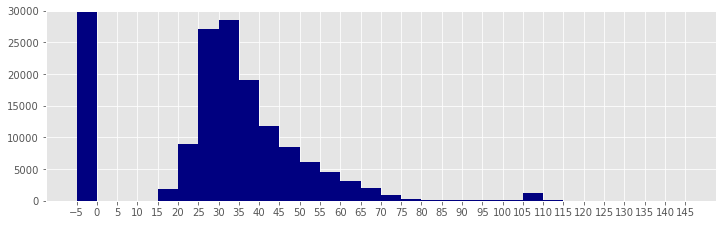

In [19]:
# look at distribution of ages, replacing nulls with -1
age_vals = train['age'].fillna(-1).values

print ('missing values:', sum(age_vals<0))
print ('values above 1900:', sum(age_vals>1900))

plt.hist(age_vals, bins=range(-5,150,5), color='navy')
plt.gcf().set_size_inches(12,3.5)
plt.xticks(range(-5,150,5))
plt.ylim(0,30000)
plt.show()

### Age Gender buckets csv file
    

This file contains summary statistics of users' age group, gender, country of destination.

In [20]:
# load the age gender buckets data
zf = zipfile.ZipFile('../airbnb/age_gender_bkts.csv.zip')
bkts = pd.read_csv(zf.open('age_gender_bkts.csv'))
bkts.tail(3)

,age_bucket,country_destination,gender,population_in_thousands,year
417,15-19,US,female,10570.0,2015.0
418,85-89,US,male,1441.0,2015.0
419,80-84,US,male,2442.0,2015.0


country_destination,age_bucket,gender,AU,CA,DE,ES,FR,GB,IT,NL,PT,US
10,25-29,female,851.0,1220.0,2495.0,1280.0,2041.0,2122.0,1610.0,505.0,299.0,11011.0
11,25-29,male,895.0,1273.0,2593.0,1347.0,2081.0,2213.0,1673.0,518.0,309.0,11385.0


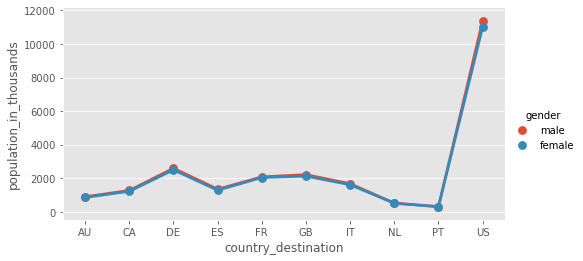

In [21]:
# create pivot table of age/gender buckets
pivot_bkts = bkts.pivot_table('population_in_thousands', ['age_bucket', 'gender'], ['country_destination'])
pivot_bkts = pd.DataFrame(pivot_bkts).reset_index()

# look at specific age buckets
choose_age = '25-29'
sns.factorplot(x="country_destination", y="population_in_thousands", \
               data=bkts[bkts.age_bucket==choose_age], hue='gender', \
               size=3.5, aspect=2.)
pivot_bkts[pivot_bkts.age_bucket==choose_age]

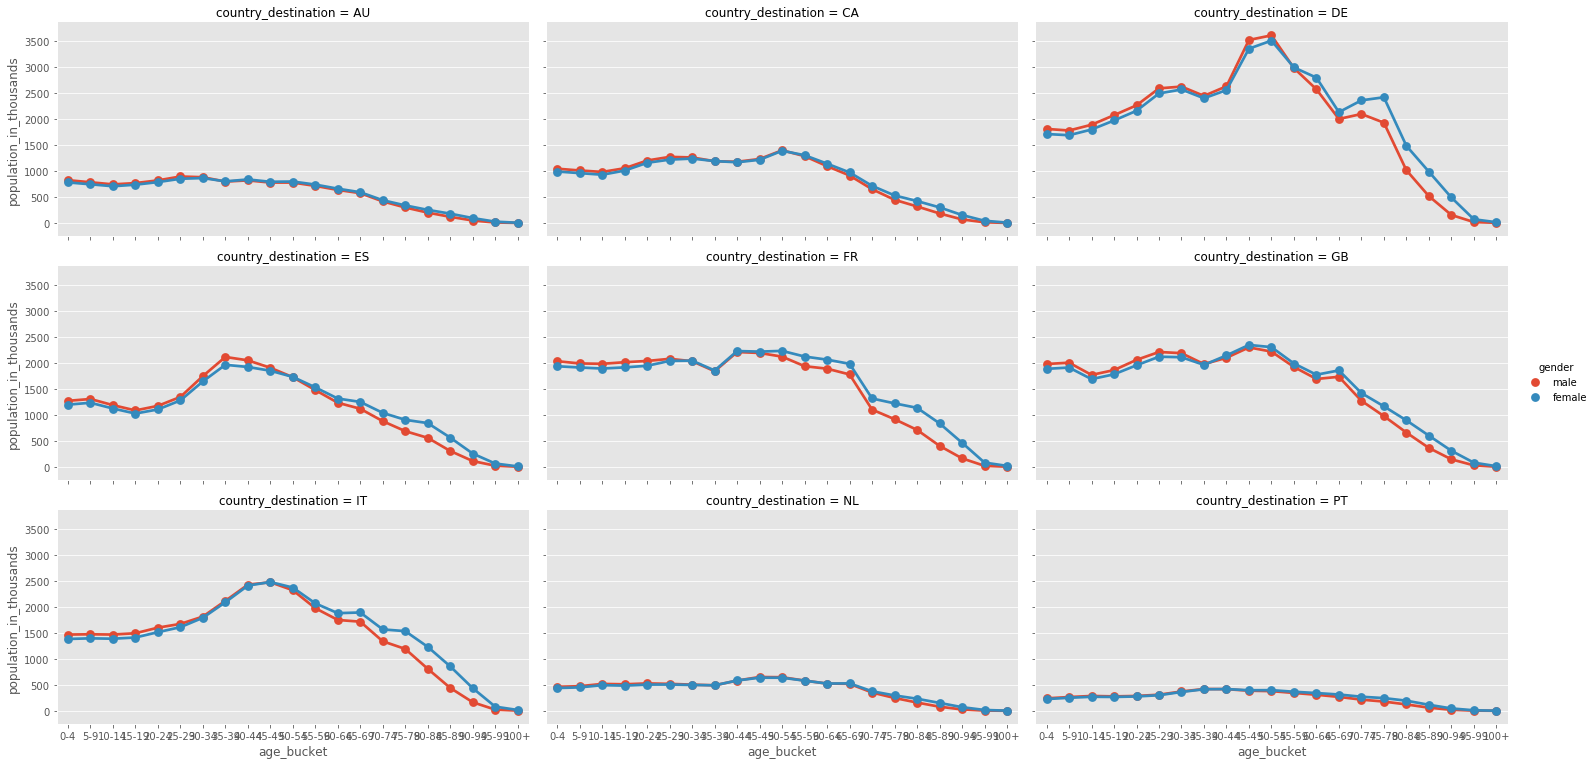

In [22]:
# look at the countries other than US
age_order = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', 
             '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+']
ax = sns.factorplot(x="age_bucket", y="population_in_thousands", \
                    data=bkts[bkts.country_destination!='US'], hue='gender', \
                    size=3.5, aspect=2, order=age_order, \
                    col='country_destination', col_wrap=3)

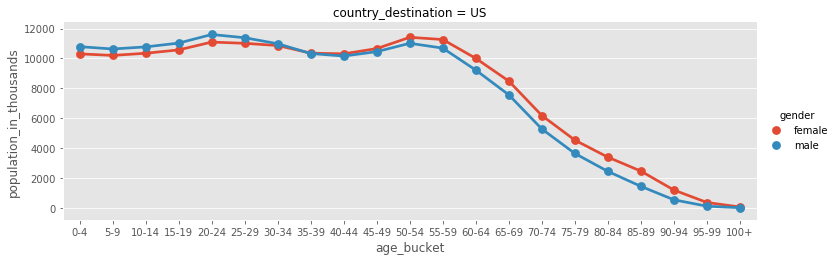

In [23]:
# look at US only
ax = sns.factorplot(x="age_bucket", y="population_in_thousands", \
                    data=bkts[bkts.country_destination=='US'], hue='gender', \
                    size=3.5, aspect=3., order=age_order, \
                    col='country_destination', col_wrap=1)

### Countries csv file

Earlier tests were performed that joined language_levenshtein_distance to the rest of the user data on destination_language, but the feature did not improve prediction accuracy. We will not use it or any other data from this file in the final solution.

In [24]:
# load the countries data
zf = zipfile.ZipFile('../airbnb/countries.csv.zip')
countries = pd.read_csv(zf.open('countries.csv'))
countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610.0,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340.0,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543.0,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090.0,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675.0,eng,0.00


## Solution implementation

In [25]:
# drop the target variable from train and merge with test data
df_train = train.drop(['country_destination'], axis=1)
df_test = test.copy()
df_all = pd.concat((df_train, df_test), axis=0, ignore_index=True)

# Remove date_first_booking, it will not be used to make predictions
df_all = df_all.drop(['date_first_booking'], axis=1)

# Fill nan
df_all = df_all.fillna(-1)

### Data features

In [26]:
# Convert date_account_created
# split date into year, month, day and create list
dac = np.vstack(df_all.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)

# create new columns for year, month, day
df_all['dac_year'] = dac[:,0]
df_all['dac_month'] = dac[:,1]
df_all['dac_day'] = dac[:,2]
df_all.head(3)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,-1.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,5,25
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,9,28


In [25]:
# Convert timestamp_first_active
# convert date to yyyymmdd
df_all['timestamp_first_active'] = df_all.timestamp_first_active//1000000

# stack yyyy, mm, dd as list
tfa = np.vstack(df_all.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8]]))).values)

# create new columns for year, month, day
df_all['tfa_year'] = tfa[:,0]
df_all['tfa_month'] = tfa[:,1]
df_all['tfa_day'] = tfa[:,2]
df_all.head(3)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,dac_year,dac_month,dac_day,tfa_year,tfa_month,tfa_day
0,gxn3p5htnn,2010-06-28,20090319,-unknown-,-1.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2010,6,28,2009,3,19
1,820tgsjxq7,2011-05-25,20090523,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,2011,5,25,2009,5,23
2,4ft3gnwmtx,2010-09-28,20090609,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,2010,9,28,2009,6,9


In [27]:
## remove old cols
df_all = df_all.drop(['date_account_created'], axis=1)
df_all = df_all.drop(['timestamp_first_active'], axis=1)
df_all.shape

(275547, 15)

### Age feature

In [28]:
# get the age values
av = df_all.age.values
# Option 1: treat ages 100+ same as na (convert to -1)
ages_option1 = np.where(av>99, -1, av)
# Option 2: convert ages 1900+ to an assumed age
ages_option2 = np.where(av>1900, 2015-av, av)

df_all['age'] = ages_option1

### One hot encoding non-numerical features

We'll engineer categorical data so that each value gets a separate column with a 1 or 0 value.

In [29]:
#One-hot-encoding features
ohe_feats = ['gender', 'signup_method', 'signup_flow', 'language', 'affiliate_channel', \
             'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
for f in ohe_feats:
    df_all_dummy = pd.get_dummies(df_all[f], prefix=f)
    df_all = df_all.drop([f], axis=1)
    df_all = pd.concat((df_all, df_all_dummy), axis=1)
df_all.head(3)

,id,age,dac_year,dac_month,dac_day,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,...,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser
0,gxn3p5htnn,-1.0,2010,6,28,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,820tgsjxq7,38.0,2011,5,25,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4ft3gnwmtx,56.0,2010,9,28,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Prepare data for fitting the classifier

In [30]:
#Split data back into train and test sets
vals = df_all.drop(['id'], axis=1).values
piv_train = train.shape[0]
X = vals[:piv_train]
X_test = vals[piv_train:]

# Create numeric label for each of the 12 target labels
labels = train['country_destination'].values
le = LabelEncoder()
y = le.fit_transform(labels)


In [31]:
print (X.shape)
print (y.shape)
print (X_test.shape)

(213451, 158)
(213451,)
(62096, 158)


### Fit the classifier

In [32]:
"""Metrics to compute the model performance."""
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    """Discounted cumulative gain (DCG) at rank K.
    
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
        Rank.
        
    Returns
    -------
    score : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
    """Normalized discounted cumulative gain (NDCG) at rank K.

    Normalized Discounted Cumulative Gain (NDCG) measures the performance of a
    recommendation system based on the graded relevance of the recommended
    entities. It varies from 0.0 to 1.0, with 1.0 representing the ideal
    ranking of the entities.

    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.

    Returns
    -------
    score : float

    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    #lb.fit(range(len(predictions) + 1))  ## original
    #lb.fit(range(predictions.shape[1] + 1))
    #T = lb.transform(ground_truth)
    
    T = lb.fit_transform(ground_truth) 

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)

# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

### Random forest
Fit the model with grid search

In [33]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=25, random_state=101)
parameters = {'min_samples_split': [2, 20],
              'max_depth': [6, 8]
             }
reg = GridSearchCV(clf, parameters, scoring=ndcg_scorer, cv=3)
t0 = time.time()
reg.fit(X, y)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=25,
                                              random_state=101),
             param_grid={'max_depth': [6, 8], 'min_samples_split': [2, 20]},
             scoring=make_scorer(ndcg_score, needs_proba=True, k=5))

### Use Spark-sklearn to speed it up

In [34]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=25, random_state=101)
parameters = {'min_samples_split': [2, 20],
              'max_depth': [6, 12]
             }
reg = GridSearchCV(clf, parameters, scoring=ndcg_scorer, cv=3)
t0 = time.time()
reg.fit(X, y)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_estimators=25,
                                              random_state=101),
             param_grid={'max_depth': [6, 12], 'min_samples_split': [2, 20]},
             scoring=make_scorer(ndcg_score, needs_proba=True, k=5))

In [35]:
## get the best predictor
est = reg.best_estimator_
est

RandomForestClassifier(max_depth=6, min_samples_split=20, n_estimators=25,
                       random_state=101)

In [36]:
# look at how well the model predicts the training data
print ('Random Forest:\n', metrics.classification_report(y, est.predict(X)))

Random Forest:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       539
           1       0.00      0.00      0.00      1428
           2       0.00      0.00      0.00      1061
           3       0.00      0.00      0.00      2249
           4       0.00      0.00      0.00      5023
           5       0.00      0.00      0.00      2324
           6       0.00      0.00      0.00      2835
           7       0.59      1.00      0.74    124543
           8       0.00      0.00      0.00       762
           9       0.00      0.00      0.00       217
          10       0.58      0.01      0.02     62376
          11       0.00      0.00      0.00     10094

    accuracy                           0.59    213451
   macro avg       0.10      0.08      0.06    213451
weighted avg       0.51      0.59      0.44    213451



In [38]:
# make predictions on test set
ypred_sub = est.predict_proba(X_test)
print(ypred_sub.shape)  ## should be (62096, 12)

# take the 5 classes with highest probabilities
id_test = test['id']
ids = []  # to hold ids
cts = []  # to hold top 1-5 predicted countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(ypred_sub[i])[::-1])[:5].tolist()
    # use this value for cts for benchmark submission 
    #cts += ['NDF', 'US', 'other', 'FR', 'IT']
    
print (len(ids)) ## should be 310480
print (len(cts))

(62096, 12)
310480
310480


In [39]:
# stack ids and countries together into dataframe
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])

# write dataframe to csv
sub.to_csv(r'../airbnb/randomforest.csv' ,index = False)

### Improving the solution
* Revisit age feature
* Merge sessions data
* Train XGBoost classifier

### Revisit age feature

We'll now use Option 2 to deal with the age values >99.

In [40]:
# Option 2: convert ages 1900+ to an assumed age
df_all['age'] = ages_option2
df_all['age'].unique()

array([ -1.,  38.,  56.,  42.,  41.,  46.,  47.,  50.,  36.,  37.,  33.,
        31.,  29.,  30.,  40.,  26.,  32.,  35.,  59.,  49.,  44.,  34.,
        28.,  19.,  53.,  52.,  39.,  57.,  25.,  54.,  69.,  63.,  43.,
        55.,  65.,  58.,  61.,  18.,   5.,  27.,  45.,  60.,  48.,  51.,
        64.,  72.,  70.,  67.,  73.,   1., 104.,  66., 105.,  68.,  95.,
        24.,  94.,  75.,  79.,  62.,   2.,  16.,   4.,  23., 101.,  98.,
        76.,  74.,  87.,  92., 115.,  71.,  84., 107.,  78.,  99., 110.,
       102.,  82.,  77.,  22.,  89.,  21.,  15.,  20., 103.,  17.,  86.,
        97.,  81.,  90.,  88.,  80., 100.,  91., 106.,  83.,  85., 108.,
       113., 109.,  93.,  96., 111., 112., 150., 132.,   7.,  14.,  13.])

### Merge data

We will utilize the sessions data by grouping users by user_id and action_detail and counting each unique action_detail event per user_id. This is then joined with our user data.

In [41]:
# Load session data
zf = zipfile.ZipFile('../airbnb//sessions.csv.zip')
sessions = pd.read_csv(zf.open('sessions.csv'))
print (sessions.shape)
sessions.head(3)

(10567737, 6)


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0


In [42]:
# group sessions by user and action_detail
group_uu = sessions.groupby(['user_id', 'action_detail'], as_index=True)
# count events and convert groupby to dataframe
events_uu = pd.DataFrame({'event_count' : group_uu.size() }).reset_index()
events_uu.head(3)

,user_id,action_detail,event_count
0,00023iyk9l,change_trip_characteristics,2
1,00023iyk9l,confirm_email_link,1
2,00023iyk9l,dashboard,4


In [43]:
# convert action_detail types to columns with pivot table
pivot_uu = events_uu.pivot_table('event_count', ['user_id'], ['action_detail'])
pivot_uu = pd.DataFrame(pivot_uu.fillna(0)).reset_index()
# drop 'unknown' events
pivot_uu = pivot_uu.drop(['-unknown-'], axis=1)
pivot_uu.head(3)

action_detail,user_id,account_notification_settings,account_payment_methods,account_payout_preferences,account_privacy_settings,account_transaction_history,admin_templates,airbnb_picks_wishlists,alteration_field,alteration_request,...,view_resolutions,view_search_results,view_security_checks,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips
0,00023iyk9l,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0
1,0010k6l0om,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0
2,001wyh0pz8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,66.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# left join sessions data to user data
df_merged = pd.merge(left=df_all, right=pivot_uu, how='left', left_on='id', right_on='user_id')
# fill in nulls after the left join
df_merged = df_merged.fillna(0)
df_merged.head(3)

,id,age,dac_year,dac_month,dac_day,gender_-unknown-,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_basic,...,view_resolutions,view_search_results,view_security_checks,view_user_real_names,wishlist,wishlist_content_update,wishlist_note,your_listings,your_reservations,your_trips
0,gxn3p5htnn,-1.0,2010,6,28,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,820tgsjxq7,38.0,2011,5,25,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4ft3gnwmtx,56.0,2010,9,28,0,1,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# Split data back into train and testsets
vals = df_merged.drop(['id', 'user_id'], axis=1).values
piv_train = train.shape[0]
X = vals[:piv_train]
X_test = vals[piv_train:]

print (X.shape)
print (y.shape)
print (X_test.shape)

(213451, 312)
(213451,)
(62096, 312)


### Train XGBoost classifier


In [46]:
# split training data into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.02, random_state=101)

In [47]:
# get our classifier
est = XGBClassifier(max_depth=6, learning_rate=0.25, n_estimators=50, gamma=0,
                    objective='multi:softprob', subsample=0.8, colsample_bytree=0.7, seed=101)

In [48]:
# fit the model and show results for both train and valid sets
my_eval_set = [(X_train,y_train), (X_valid,y_valid)]
est.fit(X_train, y_train, eval_set=my_eval_set, early_stopping_rounds=20, eval_metric='merror')

[0]	validation_0-merror:0.38392	validation_1-merror:0.39274
[1]	validation_0-merror:0.36807	validation_1-merror:0.37705
[2]	validation_0-merror:0.36597	validation_1-merror:0.37213
[3]	validation_0-merror:0.36373	validation_1-merror:0.37190
[4]	validation_0-merror:0.36269	validation_1-merror:0.37190
[5]	validation_0-merror:0.35252	validation_1-merror:0.36089
[6]	validation_0-merror:0.35091	validation_1-merror:0.36066
[7]	validation_0-merror:0.35047	validation_1-merror:0.35972
[8]	validation_0-merror:0.34918	validation_1-merror:0.35738
[9]	validation_0-merror:0.34799	validation_1-merror:0.35808
[10]	validation_0-merror:0.34731	validation_1-merror:0.35785
[11]	validation_0-merror:0.34697	validation_1-merror:0.35644
[12]	validation_0-merror:0.34611	validation_1-merror:0.35597
[13]	validation_0-merror:0.34594	validation_1-merror:0.35714
[14]	validation_0-merror:0.34566	validation_1-merror:0.35761
[15]	validation_0-merror:0.34535	validation_1-merror:0.35878
[16]	validation_0-merror:0.34506	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=101, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=101, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

### How accurate are the predicitions?

Below we can see that the xgboost model predicts more classes than the random forest model.

In [49]:
# look at NDCG score on validation set
ndcg_score(y_valid, est.predict_proba(X_valid))

0.8318294732700295

In [51]:
# look at how well the model predicts the training data
# predict class probabilities
ypred_prob = est.predict_proba(X)
# predict classes
ypred = np.argmax(ypred_prob, axis=1)
print ('XGBoost:\n', metrics.classification_report(y, ypred))

XGBoost:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       539
           1       1.00      0.00      0.00      1428
           2       1.00      0.01      0.01      1061
           3       1.00      0.00      0.01      2249
           4       0.94      0.01      0.01      5023
           5       1.00      0.00      0.01      2324
           6       1.00      0.01      0.02      2835
           7       0.71      0.86      0.78    124543
           8       1.00      0.01      0.01       762
           9       0.00      0.00      0.00       217
          10       0.52      0.53      0.52     62376
          11       0.92      0.00      0.01     10094

    accuracy                           0.66    213451
   macro avg       0.76      0.12      0.12    213451
weighted avg       0.68      0.66      0.61    213451

